## ML for Compressor units
This notebooks is a showcase example as part of the broader business case presentation to a growing local
compressor equipment manufacturer on how AI (in particular ML) can help predict air or fluid compressor parameters
and help optimize it's performance.

The compressor manufacturer currently has 2 small production sites, but is growing rapidly. The manufacturer also has the engineering team that is already doing the Control systems for compessors and approached us (as we know each other for long time) if / how AI / ML can be integrated there. Despite various solutions available on the market, the manufacturer considers to build own (as it's compressors work in a special environment).

As of 01.09.2023 the project is on initial stage of discussing with the manufacturer. The code below isin development and is very basic yet. It serves the purpose of illustrating the opportunity. 

In [1]:
import pandas as pd
import numpy as np


In [2]:
data = pd.read_csv("compressor data.csv", sep = ",")

#%%

x_data = data.drop(["id","acmotor"],axis=1)

x_data.bearings = [0 if each == "Ok" else 1 for each in data.bearings]
x_data.wpump = [0 if each == "Ok" else 1 for each in data.wpump]
x_data.radiator = [0 if each == "Clean" else 1 for each in data.radiator]
x_data.exvalve = [0 if each == "Clean" else 1 for each in data.exvalve]

# 0 = Ok, 1 = Noisy for bearings abd water pump
# 0 = Clean, 1 = Dirty for radiator and exhaust valve

In [3]:
data.head(1)

id  rpm  motor_power     torque  outlet_pressure_bar    air_flow  \
0   1  499  1405.842858  27.511708                  1.0  308.289879   

    noise_db  outlet_temp  wpump_outlet_press  water_inlet_temp  ...  \
0  40.840517    78.554715            2.960632         43.166392  ...   

      gaccy     gaccz     haccx     haccy     haccz  bearings  wpump  \
0  0.383773  2.649801  1.213344  1.409218  2.962484        Ok     Ok   

   radiator  exvalve  acmotor  
0     Clean    Clean   Stable  

[1 rows x 26 columns]

In [4]:
#%%

maxval = np.max(x_data)
minval = np.min(x_data)
std_dv = np.std(x_data)
mean = np.mean(x_data)

print(maxval,minval)


rpm                     2520.000000
motor_power            19454.559080
torque                    93.540405
outlet_pressure_bar        8.664000
air_flow                1539.911634
noise_db                  74.401986
outlet_temp              172.711382
wpump_outlet_press         4.295136
water_inlet_temp         137.543531
water_outlet_temp        161.123805
wpump_power              235.342910
water_flow                59.174992
oilpump_power            301.435483
oil_tank_temp             46.755690
gaccx                      0.726604
gaccy                      0.459811
gaccz                      9.209166
haccx                      1.227134
haccy                      1.461809
haccz                      6.107852
bearings                   1.000000
wpump                      1.000000
radiator                   1.000000
exvalve                    1.000000
dtype: float64 rpm                     480.000000
motor_power            1402.424603
torque                   13.222197
outlet_pressure_

C:\Users\georg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\georg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\georg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3430: FutureWarni

In [5]:

splitted_data = np.split(x_data, [20], axis=1)
x_data = splitted_data[0]
y_data = splitted_data[1]

In [6]:
col_names = x_data.columns.values.tolist()

norm_minmaxdata = {'minnorm': [0,0,0,0,0,30,60,0,30,30,200,30,250,40,0,0,0,0,0,0], 'maxnorm': [3000,25000,150,12,1800,100,200,6,150,200,275,80,320,50,2,2,12,2,2,10]}
norm_minmax = pd.DataFrame(norm_minmaxdata, columns = ['minnorm','maxnorm'])

minnorm = norm_minmax.minnorm.values
maxnorm = norm_minmax.maxnorm.values

In [7]:
#%%

x_norm = (x_data - minnorm)/(maxnorm-minnorm)

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Input, Flatten
from keras.optimizers import SGD

In [9]:
model = Sequential()
model.add(Dense(32,input_dim=20))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(4))
model.add(Activation('relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                672       
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 2

In [10]:
model.compile(optimizer = "rmsprop", loss = 'mse',metrics=['accuracy'])

In [11]:
history = model.fit(x_norm,y_data,epochs=100, batch_size = 25, validation_split=0.2)

Epoch 1/100
32/32 [==============================] - 2s 18ms/step - loss: 0.1983 - accuracy: 0.3413 - val_loss: 0.1887 - val_accuracy: 0.4300
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.1820 - accuracy: 0.3100 - val_loss: 0.1600 - val_accuracy: 0.2850
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.1664 - accuracy: 0.3850 - val_loss: 0.1431 - val_accuracy: 0.7050
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.1523 - accuracy: 0.4437 - val_loss: 0.1272 - val_accuracy: 0.7700
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.1424 - accuracy: 0.4900 - val_loss: 0.1175 - val_accuracy: 0.8400
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 0.1317 - accuracy: 0.5625 - val_loss: 0.1095 - val_accuracy: 0.9350
Epoch 7/100
32/32 [==============================] - 0s 5ms/step - loss: 0.1241 - accuracy: 0.6137 - val_loss: 0.1009 - val_accuracy: 0.9150
Epoch 8/100


In [13]:
score = model.evaluate(x_norm, y_data,verbose=0)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])


Test Loss: 0.003906794358044863
Test accuracy: 1.0


In [14]:
y_test_pred = model.predict(x_norm, verbose=1)
y_test_pred_class = np.argmax(y_test_pred, axis=1)

32/32 [==============================] - 0s 2ms/step


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


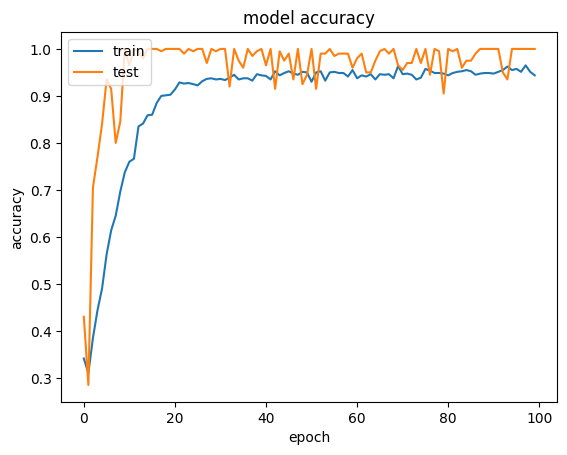

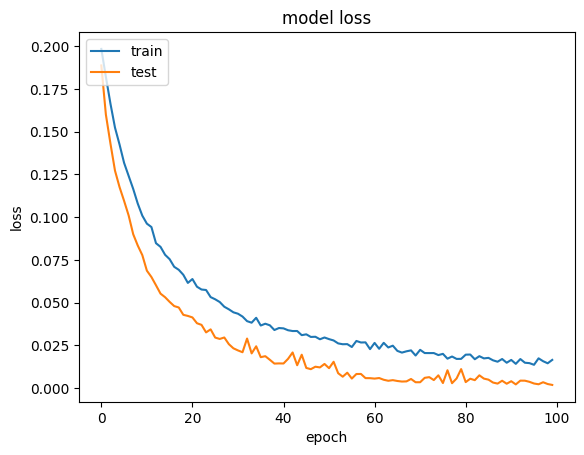

In [15]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
# Drop the id column and other categorical columns for demonstration purposes
df = pd.read_csv('compressor data.csv')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             mean_squared_error, roc_auc_score, roc_curve)
from sklearn.metrics import r2_score 


df = df.drop(['id', 'bearings', 'wpump', 'radiator', 'exvalve', 'acmotor'], axis=1)

# Define the target variable (what we want to predict) and features (predictors)
y2 = df['outlet_pressure_bar']
X2 = df.drop('outlet_pressure_bar', axis=1)


X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X2_train, y2_train)


y2_pred = model.predict(X2_test)


mse = mean_squared_error(y2_test, y2_pred)
r2 = r2_score(y2_test, y2_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.008160193069500098
R-squared: 0.9976410948329083


In [92]:
train_errors = []
validation_errors = []
n_estimators_range = range(1, 101, 10)

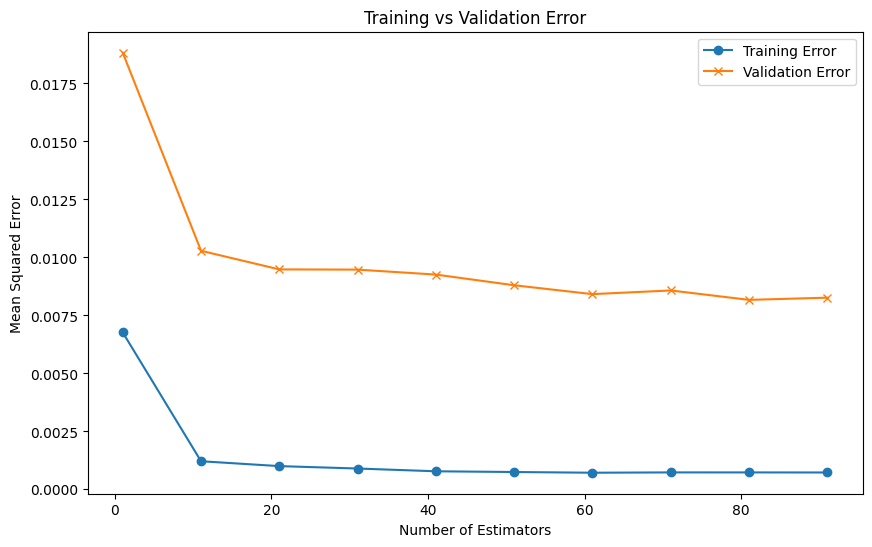

In [93]:
for n_estimators in n_estimators_range:
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(X2_train, y2_train)
    
    # Training error 
    y2_train_pred = model.predict(X2_train)
    train_mse = mean_squared_error(y2_train, y2_train_pred)
    
    # Validation error 
    y2_test_pred = model.predict(X2_test)
    val_mse = mean_squared_error(y2_test, y2_test_pred)
    
   
    train_errors.append(train_mse)
    validation_errors.append(val_mse)


plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_errors, label='Training Error', marker='o')
plt.plot(n_estimators_range, validation_errors, label='Validation Error', marker='x')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.title('Training vs Validation Error')
plt.legend()
plt.show()

In [17]:
X2_train.columns

Index(['rpm', 'motor_power', 'torque', 'air_flow', 'noise_db', 'outlet_temp',
       'wpump_outlet_press', 'water_inlet_temp', 'water_outlet_temp',
       'wpump_power', 'water_flow', 'oilpump_power', 'oil_tank_temp', 'gaccx',
       'gaccy', 'gaccz', 'haccx', 'haccy', 'haccz'],
      dtype='object')

In [18]:

# Sample new data point (replace these values with actual new data)
new_data = {
    'rpm':[500],
    'motor_power': [1405],
    'torque': [27],
    'air_flow': [308],
    'noise_db': [40],
    'outlet_temp': [78],
    'wpump_outlet_press': [2.9],
    'water_inlet_temp': [43],
    'water_outlet_temp': [47],
    'wpump_power': [216],
    'water_flow': [59],
    'oilpump_power': [300],
    'oil_tank_temp': [45.8], 
    'gaccx': [0.7],
    'gaccy': [0.37],
    'gaccz': [2.6], 
    'haccx': [1.2], 
    'haccy': [1.4],
    'haccz': [2.9]
}

new_data_df = pd.DataFrame(new_data)

# Predict using the trained Random Forest model
new_pred_rf = model.predict(new_data_df)
print(f"Random Forest Model Prediction for outlet_pressure_bar: {new_pred_rf[0]}")


Random Forest Model Prediction for outlet_pressure_bar: 1.0246199999999996


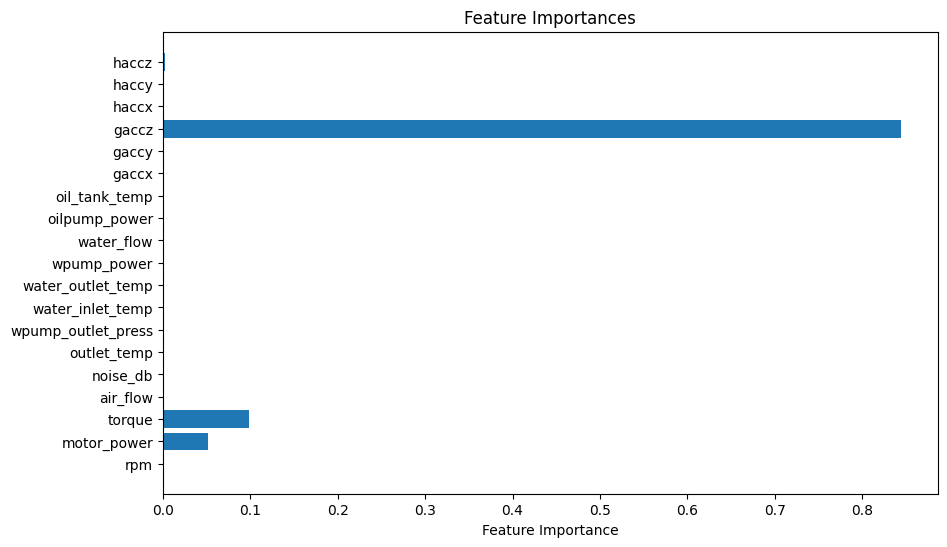

Mean Absolute Error: 0.05405335000000029
Cross-Validation Scores: [0.84158609 0.97598356 0.99665113 0.99345515 0.99684553]
Mean CV Score: 0.9609042934193287
Making Predictions...
Predictions complete.


In [19]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Feature Importance
feature_importances = model.feature_importances_
feature_names = X2_train.columns

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(X2_train.shape[1]), feature_importances, align="center")
plt.yticks(np.arange(X2_train.shape[1]), feature_names)
plt.xlabel("Feature Importance")
plt.show()

# Additional Metrics
mae = mean_absolute_error(y2_test, y2_pred)
print(f"Mean Absolute Error: {mae}")

# Cross-Validation
# Using 5-fold cross-validation
cv_scores = cross_val_score(model, X2, y2, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores)}")

# Verbose Output
# RandomForestRegressor in scikit-learn doesn't have a verbose parameter for training
# But during prediction, you can print custom messages to mimic verbose
print("Making Predictions...")
y2_pred = model.predict(X2_test)
print("Predictions complete.")


In [20]:
from catboost import CatBoostClassifier

In [21]:
df2 = pd.read_csv('compressor data.csv')

In [22]:
df2.describe()

id          rpm   motor_power       torque  \
count  1000.000000  1000.000000   1000.000000  1000.000000   
mean    500.500000  1499.516000   6984.877371    49.186120   
std     288.819436   707.681915   4269.277571    18.706750   
min       1.000000   480.000000   1402.424603    13.222197   
25%     250.750000   988.750000   3559.437042    33.749857   
50%     500.500000  1500.000000   5906.662534    48.890905   
75%     750.250000  2010.000000   9636.002782    63.672921   
max    1000.000000  2520.000000  19454.559080    93.540405   

       outlet_pressure_bar     air_flow     noise_db  outlet_temp  \
count          1000.000000  1000.000000  1000.000000  1000.000000   
mean              4.054049   754.673930    53.412121   118.855110   
std               1.862761   442.743491     8.055363    19.120181   
min               1.000000    95.098952    39.879017    76.902822   
25%               2.443750   305.388152    46.490976   104.731080   
50%               4.038000   608.626411    52.708480   118.275842   
75%               5.600250  1193.266273    60.158248   132.850790   
max               8.664000  1539.911634    74.401986   172.711382   

       wpump_outlet_press  water_inlet_temp  ...  wpump_power   water_flow  \
count         1000.000000       1000.000000  ...  1000.000000  1000.000000   
mean             2.799610         83.021711  ...   222.185445    53.708176   
std              0.455274         18.644992  ...     3.774537     6.587259   
min              1.834533         43.166392  ...   213.525207    38.570791   
25%              2.448208         68.914714  ...   219.471768    50.459245   
50%              2.780492         82.101660  ...   221.889622    58.112667   
75%              3.092101         95.792346  ...   224.721620    58.552897   
max              4.295136        137.543531  ...   235.342910    59.174992   

       oilpump_power  oil_tank_temp        gaccx        gaccy        gaccz  \
count    1000.000000    1000.000000  1000.000000  1000.000000  1000.000000   
mean      300.484123      46.237663     0.601789     0.349667     3.923073   
std         0.408703       0.196139     0.058719     0.040667     1.610130   
min       299.507859      45.806178     0.540045     0.274650     1.730301   
25%       300.187873      46.090060     0.558092     0.316543     2.576739   
50%       300.470013      46.236213     0.576814     0.349343     3.610639   
75%       300.774788      46.378237     0.615021     0.375261     5.081960   
max       301.435483      46.755690     0.726604     0.459811     9.209166   

             haccx        haccy        haccz  
count  1000.000000  1000.000000  1000.000000  
mean      1.101253     1.350042     3.495037  
std       0.058546     0.040871     0.817667  
min       1.039910     1.270696     2.329267  
25%       1.057717     1.318785     2.802622  
50%       1.075392     1.348189     3.339698  
75%       1.113696     1.375232     4.071874  
max       1.227134     1.461809     6.107852  

[8 rows x 21 columns]

In [23]:
df2.drop (columns = 'id', inplace =  True)

In [24]:
df2.columns

Index(['rpm', 'motor_power', 'torque', 'outlet_pressure_bar', 'air_flow',
       'noise_db', 'outlet_temp', 'wpump_outlet_press', 'water_inlet_temp',
       'water_outlet_temp', 'wpump_power', 'water_flow', 'oilpump_power',
       'oil_tank_temp', 'gaccx', 'gaccy', 'gaccz', 'haccx', 'haccy', 'haccz',
       'bearings', 'wpump', 'radiator', 'exvalve', 'acmotor'],
      dtype='object')

In [25]:
df2['radiator'].value_counts()

Clean    800
Dirty    200
Name: radiator, dtype: int64

In [26]:
df2['radiator'].isnull().sum()

0

In [27]:
df2.dtypes

rpm                      int64
motor_power            float64
torque                 float64
outlet_pressure_bar    float64
air_flow               float64
noise_db               float64
outlet_temp            float64
wpump_outlet_press     float64
water_inlet_temp       float64
water_outlet_temp      float64
wpump_power            float64
water_flow             float64
oilpump_power          float64
oil_tank_temp          float64
gaccx                  float64
gaccy                  float64
gaccz                  float64
haccx                  float64
haccy                  float64
haccz                  float64
bearings                object
wpump                   object
radiator                object
exvalve                 object
acmotor                 object
dtype: object

In [28]:
df2[['bearings', 'wpump', 'radiator', 'exvalve', 'acmotor']] = df2[['bearings', 'wpump', 'radiator', 'exvalve', 'acmotor']].astype(str)

In [29]:
print(type(df2['bearings'].iloc[0]))

<class 'str'>


In [30]:
X3 = df2.drop(columns = ['radiator', 'water_flow'])
y3 = df2['radiator']

In [31]:
X3_train, X3_test, y3_train, y3_test = train_test_split (X3, y3, test_size = 0.1, random_state = 42)

In [32]:
df2.columns

Index(['rpm', 'motor_power', 'torque', 'outlet_pressure_bar', 'air_flow',
       'noise_db', 'outlet_temp', 'wpump_outlet_press', 'water_inlet_temp',
       'water_outlet_temp', 'wpump_power', 'water_flow', 'oilpump_power',
       'oil_tank_temp', 'gaccx', 'gaccy', 'gaccz', 'haccx', 'haccy', 'haccz',
       'bearings', 'wpump', 'radiator', 'exvalve', 'acmotor'],
      dtype='object')

In [33]:
df2.isnull().sum()

rpm                    0
motor_power            0
torque                 0
outlet_pressure_bar    0
air_flow               0
noise_db               0
outlet_temp            0
wpump_outlet_press     0
water_inlet_temp       0
water_outlet_temp      0
wpump_power            0
water_flow             0
oilpump_power          0
oil_tank_temp          0
gaccx                  0
gaccy                  0
gaccz                  0
haccx                  0
haccy                  0
haccz                  0
bearings               0
wpump                  0
radiator               0
exvalve                0
acmotor                0
dtype: int64

In [34]:
df2[['rpm', 'motor_power', 'torque', 'outlet_pressure_bar', 'air_flow',
       'noise_db', 'outlet_temp', 'wpump_outlet_press', 'water_inlet_temp',
       'water_outlet_temp', 'wpump_power', 'water_flow', 'oilpump_power',
       'oil_tank_temp', 'gaccx', 'gaccy', 'gaccz', 'haccx', 'haccy', 'haccz']] = df2[['rpm', 'motor_power', 'torque', 'outlet_pressure_bar', 'air_flow',
       'noise_db', 'outlet_temp', 'wpump_outlet_press', 'water_inlet_temp',
       'water_outlet_temp', 'wpump_power', 'water_flow', 'oilpump_power',
       'oil_tank_temp', 'gaccx', 'gaccy', 'gaccz', 'haccx', 'haccy', 'haccz']].astype(int)

In [35]:
print(type(df2['motor_power'].iloc[0]))

<class 'numpy.int32'>


In [36]:
cat_features = ['bearings', 'wpump', 'exvalve', 'acmotor']

In [37]:
model2 = CatBoostClassifier(iterations = 500, learning_rate = 0.1, depth = 4, cat_features = cat_features, verbose = 200)

In [38]:
model2.fit (X3_train, y3_train, eval_set = (X3_test, y3_test), plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5518754	test: 0.5549842	best: 0.5549842 (0)	total: 150ms	remaining: 1m 14s
200:	learn: 0.0019491	test: 0.0040233	best: 0.0040233 (200)	total: 1.31s	remaining: 1.96s
400:	learn: 0.0008987	test: 0.0021710	best: 0.0021710 (400)	total: 2.44s	remaining: 602ms
499:	learn: 0.0008317	test: 0.0020643	best: 0.0020643 (478)	total: 3.01s	remaining: 0us

bestTest = 0.00206425599
bestIteration = 478

Shrink model to first 479 iterations.


ValueError: The number of FixedLocator locations (19), usually from a call to set_ticks, does not match the number of labels (23).

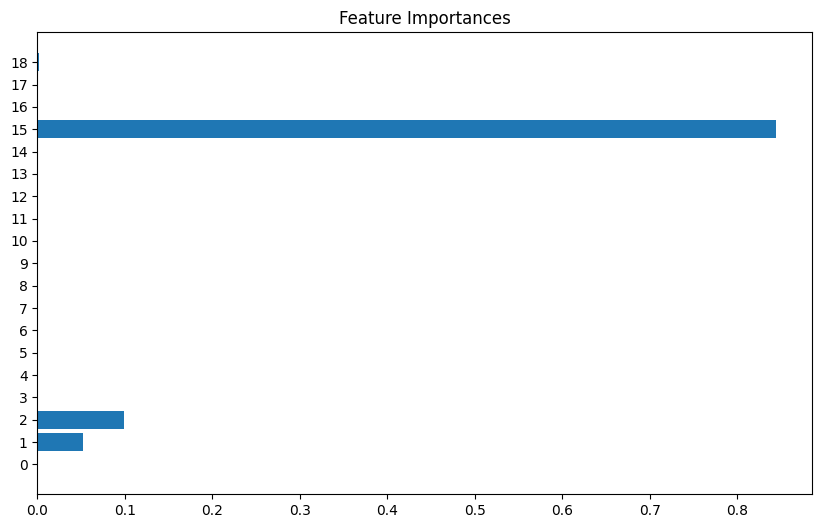

In [96]:
feature_importances = model.feature_importances_
feature_names = X3_train.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(X2_train.shape[1]), feature_importances, align="center")
plt.yticks(np.arange(X2_train.shape[1]), feature_names)
plt.xlabel("Feature Importance")
plt.show()

In [42]:
test_pool = Pool(X3_test, y3_test, cat_features=cat_features)
eval_metrics = model2.eval_metrics(data=test_pool, metrics=['Accuracy', 'Precision', 'Recall', 'F1'])

# Get the last value of each metric
print("Final Metrics:")
for metric, values in eval_metrics.items():
    print(f"{metric}: {values[-1]}")



Final Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0


In [43]:
feature_names = X3_train.columns.tolist()
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print(f"{name}: {score}")


motor_power: Importances
rpm: Feature Id


In [44]:
X_cat = pd.DataFrame({
    'rpm':[500],
    'motor_power': [1405],
    'torque': [27],
    'outlet_pressure_bar': [1.03],
    'air_flow': [308],
    'noise_db': [40],
    'outlet_temp': [78],
    'wpump_outlet_press': [2.9],
    'water_inlet_temp': [43],
    'water_outlet_temp': [47],
    'wpump_power': [216],
    'oilpump_power': [300],
    'oil_tank_temp': [45.8], 
    'gaccx': [0.7],
    'gaccy': [0.37],
    'gaccz': [2.6], 
    'haccx': [1.2], 
    'haccy': [1.4],
    'haccz': [2.9],
    'bearings': ['OK'], 
    'wpump': ['OK'], 
    'exvalve': ['Clean'], 
    'acmotor': ['Stable']
})

In [45]:
predicti_radiator = model2.predict(X_cat)
print(predicti_radiator)

['Clean']


In [46]:
X_cat2 = pd.DataFrame({
    'rpm':[1014],
    'motor_power': [3773],
    'torque': [40],
    'outlet_pressure_bar': [2.8],
    'air_flow': [188],
    'noise_db': [46],
    'outlet_temp': [96],
    'wpump_outlet_press': [2.9],
    'water_inlet_temp': [58.9],
    'water_outlet_temp': [70],
    'wpump_power': [217],
    'oilpump_power': [300],
    'oil_tank_temp': [46], 
    'gaccx': [0.61],
    'gaccy': [0.36],
    'gaccz': [2.7], 
    'haccx': [1.2], 
    'haccy': [1.4],
    'haccz': [2.9],
    'bearings': ['OK'], 
    'wpump': ['OK'], 
    'exvalve': ['Clean'], 
    'acmotor': ['Stable']
})

In [47]:
predict_radiator2 = model2.predict(X_cat2)
print(predict_radiator2)

['Dirty']


## This is showcase for Anomaly detection

In [48]:
from scipy.stats import zscore

In [65]:
df3 = df2.copy()
df3.head(1)

rpm  motor_power  torque  outlet_pressure_bar  air_flow  noise_db  \
0  499         1405      27                    1       308        40   

   outlet_temp  wpump_outlet_press  water_inlet_temp  water_outlet_temp  ...  \
0           78                   2                43                 47  ...   

   gaccy  gaccz  haccx  haccy  haccz  bearings  wpump  radiator  exvalve  \
0      0      2      1      1      2        Ok     Ok     Clean    Clean   

   acmotor  
0   Stable  

[1 rows x 25 columns]

In [66]:
df3_encoded = pd.get_dummies(df3[['bearings', 'wpump', 'exvalve','acmotor', 'radiator']])

In [67]:
df3.drop(columns = ['bearings', 'wpump', 'exvalve','acmotor', 'radiator'], inplace = True)

In [68]:
df3 = pd.concat([df3, df3_encoded], axis = 1)

In [69]:
df3.head(1)
df3.dtypes

rpm                    int32
motor_power            int32
torque                 int32
outlet_pressure_bar    int32
air_flow               int32
noise_db               int32
outlet_temp            int32
wpump_outlet_press     int32
water_inlet_temp       int32
water_outlet_temp      int32
wpump_power            int32
water_flow             int32
oilpump_power          int32
oil_tank_temp          int32
gaccx                  int32
gaccy                  int32
gaccz                  int32
haccx                  int32
haccy                  int32
haccz                  int32
bearings_Noisy         uint8
bearings_Ok            uint8
wpump_Noisy            uint8
wpump_Ok               uint8
exvalve_Clean          uint8
exvalve_Dirty          uint8
acmotor_Stable         uint8
radiator_Clean         uint8
radiator_Dirty         uint8
dtype: object

In [70]:
z_scores = np.abs(zscore(df3))

In [80]:
outliers = (z_scores > 2.5)

In [81]:
outliers_df = df3[(outliers).any(axis=1)]
print("Outliers DataFrame:")
print(outliers_df)

Outliers DataFrame:
      rpm  motor_power  torque  outlet_pressure_bar  air_flow  noise_db  \
0     499         1405      27                    1       308        40   
1     513         1457      31                    1       307        40   
2     495         1582      33                    1       307        40   
3     480         1712      36                    1       306        40   
4     498         1766      38                    1       306        41   
..    ...          ...     ...                  ...       ...       ...   
995  2485        18141      72                    6       470        66   
996  2519        18811      74                    7       476        64   
997  2514        18784      71                    7       473        60   
998  2490        18612      73                    7       468        62   
999  2499        19454      78                    7       469        61   

     outlet_temp  wpump_outlet_press  water_inlet_temp  water_outlet_temp  \
0 

In [82]:
z_scores_df = pd.DataFrame(z_scores, columns=df3.columns)

In [84]:
outlier_columns = z_scores_df.columns[(z_scores_df.loc[678] > 2.5)]
print("Outlier columns for index 678: ", outlier_columns)

Outlier columns for index 678:  Index(['motor_power', 'gaccz'], dtype='object')


In [85]:
outlier_columns = z_scores_df.columns[(z_scores_df.loc[916] > 2.5)]
print("Outlier columns for index 678: ", outlier_columns)

Outlier columns for index 678:  Index(['wpump_outlet_press'], dtype='object')


In [86]:
from sklearn.svm import OneClassSVM
one_class_svm = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
preds = one_class_svm.fit_predict(df3)


In [90]:
preds_df = pd.DataFrame(preds, columns=['Prediction'], index=df3.index)

outliers = df3[preds_df['Prediction'] == -1]

print("Outliers detected by OneClassSVM:")
print(outliers)

Outliers detected by OneClassSVM:
      rpm  motor_power  torque  outlet_pressure_bar  air_flow  noise_db  \
6     503         1885      36                    1       306        41   
7     489         1877      38                    1       306        41   
17    497         2482      51                    3       303        39   
18    499         2517      48                    3       303        42   
21    484         2748      55                    3       302        42   
..    ...          ...     ...                  ...       ...       ...   
994  2490        17483      68                    6       470        63   
995  2485        18141      72                    6       470        66   
997  2514        18784      71                    7       473        60   
998  2490        18612      73                    7       468        62   
999  2499        19454      78                    7       469        61   

     outlet_temp  wpump_outlet_press  water_inlet_temp  water_out

In [89]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(df3)
distances = kmeans.transform(df3)


C:\Users\georg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [91]:
distances = kmeans.transform(df3)
min_distances = np.min(distances, axis=1)


threshold = np.percentile(min_distances, 95)  
outliers = df3[min_distances > threshold]

print("Outliers detected by K-means:")
print(outliers)

Outliers detected by K-means:
      rpm  motor_power  torque  outlet_pressure_bar  air_flow  noise_db  \
515  1519        11349      75                    6       891        54   
516  1517        11714      77                    7       882        57   
517  1492        11720      79                    7       886        56   
518  1491        11788      77                    7       879        52   
597  1506        11445      74                    6       285        52   
598  1489        11503      73                    7       276        52   
599  1510        11673      76                    7       281        54   
628  1988        11337      59                    5      1200        55   
629  1980        11517      60                    5      1190        56   
661  2014        11491      57                    5      1207        65   
662  2003        11630      57                    5      1198        67   
676  2009        17737      89                    8      1193        6